In [1]:
import os
import optuna
import numpy as np
import pandas as pd
import football as fb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

raw_df = pd.read_excel('Copy of Accuyield_Test_Package_Data_Scientist_V3(1).xlsx', sheet_name=1)
raw_df


c:\Users\kkyao\Desktop\league_analysis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,MatchID,League,Season,Week,Round,Date,Time,HomeTeam,AwayTeam,HomeScore,...,HomeRedCards,AwayRedCards,HomeSuccessfulTackles,AwaySuccessfulTackles,HomeInterceptions,AwayInterceptions,HomeAssists,AwayAssists,HomeSubstitutionsET,AwaySubstitutionsET
0,1394661,English Premier League,2017-2018,1,1,2017-08-12,02:45:00,Arsenal,Leicester City,4,...,0,0,0,0,0,0,0,0,0,0
1,1394670,English Premier League,2017-2018,1,1,2017-08-12,19:30:00,Watford,Liverpool,3,...,0,0,0,0,0,0,0,0,0,0
2,1394663,English Premier League,2017-2018,1,1,2017-08-12,22:00:00,Chelsea,Burnley,2,...,2,0,0,0,0,0,0,0,0,0
3,1394664,English Premier League,2017-2018,1,1,2017-08-12,22:00:00,Crystal Palace,Huddersfield Town,0,...,0,0,0,0,0,0,0,0,0,0
4,1394665,English Premier League,2017-2018,1,1,2017-08-12,22:00:00,Everton,Stoke City,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2655,2399429,English Premier League,2023-2024,38,44,2024-05-19,23:00:00,Brighton Hove Albion,Manchester United,0,...,0,0,21,18,6,7,0,1,0,0
2656,2399434,English Premier League,2023-2024,38,44,2024-05-19,23:00:00,Luton Town,Fulham,2,...,0,0,9,18,5,4,0,4,0,0
2657,2399428,English Premier League,2023-2024,38,44,2024-05-19,23:00:00,Brentford,Newcastle United,2,...,0,0,15,13,5,8,2,3,0,0
2658,2399435,English Premier League,2023-2024,38,44,2024-05-19,23:00:00,Manchester City,West Ham United,3,...,0,0,19,14,6,4,3,0,0,0


In [2]:
raw_df.columns

Index(['MatchID', 'League', 'Season', 'Week', 'Round', 'Date', 'Time',
       'HomeTeam', 'AwayTeam', 'HomeScore', 'AwayScore', 'TotalGoals',
       'Result', 'HomeCornerKicks', 'AwayCornerKicks', 'HomeCornerKicksHT',
       'AwayCornerKicksHT', 'HomeYellowCards', 'AwayYellowCards', 'HomeShots',
       'AwayShots', 'HomeShotsOnGoal', 'AwayShotsOnGoal', 'HomeAttacks',
       'AwayAttacks', 'HomeDangerousAttacks', 'AwayDangerousAttacks',
       'HomeShotsOffGoal', 'AwayShotsOffGoal', 'HomeBlocked', 'AwayBlocked',
       'HomeFreeKicks', 'AwayFreeKicks', 'HomePossession', 'AwayPossession',
       'HomePossessionHT', 'AwayPossessionHT', 'HomePasses', 'AwayPasses',
       'HomeSuccessfulPassesPct', 'AwaySuccessfulPassesPct', 'HomeFouls',
       'AwayFouls', 'HomeOffsides', 'AwayOffsides', 'HomeAerials',
       'AwayAerials', 'HomeAerialsWon', 'AwayAerialsWon', 'HomeSaves',
       'AwaySaves', 'HomeTackles', 'AwayTackles', 'HomeDribbles',
       'AwayDribbles', 'HomeThrowIns', 'AwayThrowIns'

In [3]:
# use only FT records and stats i understood
df = raw_df[['MatchID', 'Season', 'Date','Time',
            'HomeTeam', 'AwayTeam', 'HomeScore', 'AwayScore', 'TotalGoals',
            'Result',
            'HomeCornerKicks', 'AwayCornerKicks', 
            'HomeYellowCards', 'AwayYellowCards', 'HomeShots',
            'AwayShots', 'HomeShotsOnGoal', 'AwayShotsOnGoal', 'HomeAttacks',
            'AwayAttacks', 'HomeDangerousAttacks', 'AwayDangerousAttacks',
            'HomeShotsOffGoal', 'AwayShotsOffGoal', 'HomeBlocked', 'AwayBlocked',
            'HomeFreeKicks', 'AwayFreeKicks', 'HomePossession', 'AwayPossession',
            'HomePasses', 'AwayPasses',
            'HomeSuccessfulPassesPct', 'AwaySuccessfulPassesPct', 'HomeFouls',
            'AwayFouls', 'HomeOffsides', 'AwayOffsides',
            'HomeAerialsWon', 'AwayAerialsWon', 'HomeSaves',
            'AwaySaves', 'HomeTackles', 'AwayTackles', 'HomeDribbles',
            'AwayDribbles', 'HomeThrowIns', 'AwayThrowIns', 'HomeHitThePost',
            'AwayHitThePost', 'HomeSubstitutions', 'AwaySubstitutions',
            'HomeRedCards', 'AwayRedCards', 'HomeSuccessfulTackles',
            'AwaySuccessfulTackles', 'HomeInterceptions', 'AwayInterceptions',
            'HomeAssists', 'AwayAssists']].copy()

df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))
df.sort_values(by='DateTime', inplace=True)
df.drop(columns=['Date', 'Time'], inplace=True)
df.reset_index(drop=True, inplace=True)

#check duplicates
duplicate_match_ids = df[df['MatchID'].duplicated()]
if not duplicate_match_ids.empty:
    print("Duplicate MatchIDs found:")
    print(duplicate_match_ids)
else:
    print("All MatchIDs are unique.")
df

All MatchIDs are unique.


,MatchID,Season,HomeTeam,AwayTeam,HomeScore,AwayScore,TotalGoals,Result,HomeCornerKicks,AwayCornerKicks,...,AwaySubstitutions,HomeRedCards,AwayRedCards,HomeSuccessfulTackles,AwaySuccessfulTackles,HomeInterceptions,AwayInterceptions,HomeAssists,AwayAssists,DateTime
0,1394661,2017-2018,Arsenal,Leicester City,4,3,7,H,9,4,...,3,0,0,0,0,0,0,0,0,2017-08-12 02:45:00
1,1394670,2017-2018,Watford,Liverpool,3,3,6,D,3,3,...,3,0,0,0,0,0,0,0,0,2017-08-12 19:30:00
2,1394663,2017-2018,Chelsea,Burnley,2,3,5,A,8,5,...,2,2,0,0,0,0,0,0,0,2017-08-12 22:00:00
3,1394664,2017-2018,Crystal Palace,Huddersfield Town,0,3,3,A,12,9,...,3,0,0,0,0,0,0,0,0,2017-08-12 22:00:00
4,1394665,2017-2018,Everton,Stoke City,1,0,1,H,6,6,...,2,0,0,0,0,0,0,0,0,2017-08-12 22:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2655,2399430,2023-2024,Burnley,Nottingham Forest,1,2,3,A,4,3,...,5,0,0,5,16,7,13,1,2,2024-05-19 23:00:00
2656,2399433,2023-2024,Liverpool,Wolves,2,0,2,H,10,2,...,5,0,1,23,23,9,5,1,0,2024-05-19 23:00:00
2657,2399427,2023-2024,Arsenal,Everton,2,1,3,H,8,1,...,2,0,0,7,17,7,5,2,0,2024-05-19 23:00:00
2658,2399432,2023-2024,Crystal Palace,Aston Villa,5,0,5,H,2,4,...,4,0,0,19,10,3,3,4,0,2024-05-19 23:00:00


In [4]:
df_with_elo_by_season = fb.compute_elo_factors_by_season(df,initial_value=200, decay_rate=0.95)
df_with_elo_by_season

Processed season: 2017-2018
Processed season: 2018-2019
Processed season: 2019-2020
Processed season: 2020-2021
Processed season: 2021-2022
Processed season: 2022-2023
Processed season: 2023-2024


,MatchID,Season,HomeTeam,AwayTeam,HomeScore,AwayScore,TotalGoals,Result,HomeCornerKicks,AwayCornerKicks,...,AwayRedCards,HomeSuccessfulTackles,AwaySuccessfulTackles,HomeInterceptions,AwayInterceptions,HomeAssists,AwayAssists,DateTime,Home_Elo_Factor,Away_Elo_Factor
0,1394661,2017-2018,Arsenal,Leicester City,4,3,7,H,9,4,...,0,0,0,0,0,0,0,2017-08-12 02:45:00,200.000000,200.000000
1,1394670,2017-2018,Watford,Liverpool,3,3,6,D,3,3,...,0,0,0,0,0,0,0,2017-08-12 19:30:00,200.000000,200.000000
2,1394663,2017-2018,Chelsea,Burnley,2,3,5,A,8,5,...,0,0,0,0,0,0,0,2017-08-12 22:00:00,200.000000,200.000000
3,1394664,2017-2018,Crystal Palace,Huddersfield Town,0,3,3,A,12,9,...,0,0,0,0,0,0,0,2017-08-12 22:00:00,200.000000,200.000000
4,1394665,2017-2018,Everton,Stoke City,1,0,1,H,6,6,...,0,0,0,0,0,0,0,2017-08-12 22:00:00,200.000000,200.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2655,2399430,2023-2024,Burnley,Nottingham Forest,1,2,3,A,4,3,...,0,5,16,7,13,1,2,2024-05-19 23:00:00,29.978051,29.978051
2656,2399433,2023-2024,Liverpool,Wolves,2,0,2,H,10,2,...,1,23,23,9,5,1,0,2024-05-19 23:00:00,29.978051,29.978051
2657,2399427,2023-2024,Arsenal,Everton,2,1,3,H,8,1,...,0,7,17,7,5,2,0,2024-05-19 23:00:00,29.978051,29.978051
2658,2399432,2023-2024,Crystal Palace,Aston Villa,5,0,5,H,2,4,...,0,19,10,3,3,4,0,2024-05-19 23:00:00,29.978051,29.978051


- elo_factor are used for adjusting the elo rating of a team with a certain decay rate and it will reset to 200 after each season.
- Purpose: To dynamically adjust the elo rating of a team based on the performance of the team at the beginning of the season.

<Axes: >

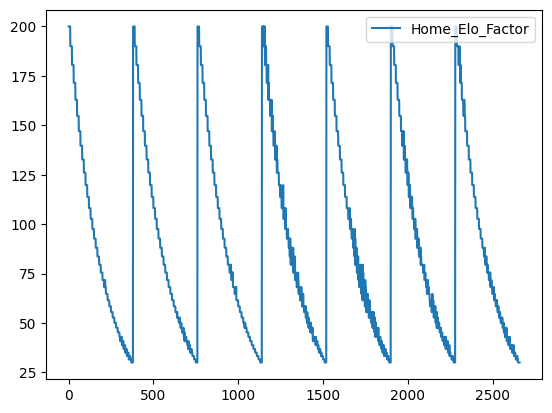

In [5]:
df_with_elo_by_season[['Home_Elo_Factor']].plot()

- Home field advantage are included here and can be optimized in the future. (lower it if home advantage is not significant)
- elo_adjustment after each game for example: 
    - new_elo_ratings = original_elo + decay_factor * (ActualScore - ExpectedScore)

In [6]:
df, elo_ratings = fb.compute_expected_scores(df_with_elo_by_season, initial_elo=1500, home_field_advantage=100)
print(f'Final_Elo: {elo_ratings}')
df

Final_Elo: {'Arsenal': 1857.7645553556806, 'Leicester City': 1447.1368956631788, 'Watford': 1285.9028615200043, 'Liverpool': 1793.1436110970074, 'Chelsea': 1692.0933781401166, 'Burnley': 1369.6871808137646, 'Crystal Palace': 1563.4135095663466, 'Huddersfield Town': 1180.319407488894, 'Everton': 1564.1435059210698, 'Stoke City': 1347.9756516514262, 'West Bromwich': 1362.750946167842, 'AFC Bournemouth': 1555.6199578515884, 'Southampton': 1349.6397337329279, 'Swansea City': 1369.1738425343176, 'Brighton Hove Albion': 1526.6584413841078, 'Manchester City': 1891.2379930517584, 'Newcastle United': 1615.8070717402968, 'Tottenham Hotspur': 1636.6583594832125, 'Manchester United': 1645.2042865333008, 'West Ham United': 1549.6595283752395, 'Fulham': 1541.4853006775481, 'Cardiff City': 1375.740327698392, 'Wolves': 1506.1376277013621, 'Norwich City': 1314.2988894499717, 'Sheffield United': 1277.2342075361144, 'Aston Villa': 1665.5381967312474, 'Leeds United': 1389.7041450127633, 'Brentford': 1467.

,MatchID,Season,HomeTeam,AwayTeam,HomeScore,AwayScore,TotalGoals,Result,HomeCornerKicks,AwayCornerKicks,...,AwayAssists,DateTime,Home_Elo_Factor,Away_Elo_Factor,ExpectedHomeScore,ExpectedAwayScore,Home_Old_Elo,Home_New_Elo,Away_Old_Elo,Away_New_Elo
0,1394661,2017-2018,Arsenal,Leicester City,4,3,7,H,9,4,...,0,2017-08-12 02:45:00,200.000000,200.000000,0.640065,0.359935,1500.000000,1571.987000,1500.000000,1428.013000
1,1394670,2017-2018,Watford,Liverpool,3,3,6,D,3,3,...,0,2017-08-12 19:30:00,200.000000,200.000000,0.640065,0.359935,1500.000000,1471.987000,1500.000000,1528.013000
2,1394663,2017-2018,Chelsea,Burnley,2,3,5,A,8,5,...,0,2017-08-12 22:00:00,200.000000,200.000000,0.640065,0.359935,1500.000000,1371.987000,1500.000000,1628.013000
3,1394664,2017-2018,Crystal Palace,Huddersfield Town,0,3,3,A,12,9,...,0,2017-08-12 22:00:00,200.000000,200.000000,0.640065,0.359935,1500.000000,1371.987000,1500.000000,1628.013000
4,1394665,2017-2018,Everton,Stoke City,1,0,1,H,6,6,...,0,2017-08-12 22:00:00,200.000000,200.000000,0.640065,0.359935,1500.000000,1571.987000,1500.000000,1428.013000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2655,2399430,2023-2024,Burnley,Nottingham Forest,1,2,3,A,4,3,...,2,2024-05-19 23:00:00,29.978051,29.978051,0.575196,0.424804,1386.930433,1369.687181,1434.279583,1451.522836
2656,2399433,2023-2024,Liverpool,Wolves,2,0,2,H,10,2,...,0,2024-05-19 23:00:00,29.978051,29.978051,0.899632,0.100368,1790.134781,1793.143611,1509.146457,1506.137628
2657,2399427,2023-2024,Arsenal,Everton,2,1,3,H,8,1,...,0,2024-05-19 23:00:00,29.978051,29.978051,0.903124,0.096876,1854.860406,1857.764555,1567.047655,1564.143506
2658,2399432,2023-2024,Crystal Palace,Aston Villa,5,0,5,H,2,4,...,0,2024-05-19 23:00:00,29.978051,29.978051,0.449625,0.550375,1546.914353,1563.413510,1682.037354,1665.538197


Possible improvements:
- Add Goals difference between strong and weak team into account for Elo rating adjustment
- For example: 
    - if weak team wins by 1 goals, the elo should increased more than strong team won by 1 goals
    - if strong team wins by 1 goals, the elo shouldn't increase too much

In [7]:
elo_ratings

{'Arsenal': 1857.7645553556806,
 'Leicester City': 1447.1368956631788,
 'Watford': 1285.9028615200043,
 'Liverpool': 1793.1436110970074,
 'Chelsea': 1692.0933781401166,
 'Burnley': 1369.6871808137646,
 'Crystal Palace': 1563.4135095663466,
 'Huddersfield Town': 1180.319407488894,
 'Everton': 1564.1435059210698,
 'Stoke City': 1347.9756516514262,
 'West Bromwich': 1362.750946167842,
 'AFC Bournemouth': 1555.6199578515884,
 'Southampton': 1349.6397337329279,
 'Swansea City': 1369.1738425343176,
 'Brighton Hove Albion': 1526.6584413841078,
 'Manchester City': 1891.2379930517584,
 'Newcastle United': 1615.8070717402968,
 'Tottenham Hotspur': 1636.6583594832125,
 'Manchester United': 1645.2042865333008,
 'West Ham United': 1549.6595283752395,
 'Fulham': 1541.4853006775481,
 'Cardiff City': 1375.740327698392,
 'Wolves': 1506.1376277013621,
 'Norwich City': 1314.2988894499717,
 'Sheffield United': 1277.2342075361144,
 'Aston Villa': 1665.5381967312474,
 'Leeds United': 1389.7041450127633,
 'B

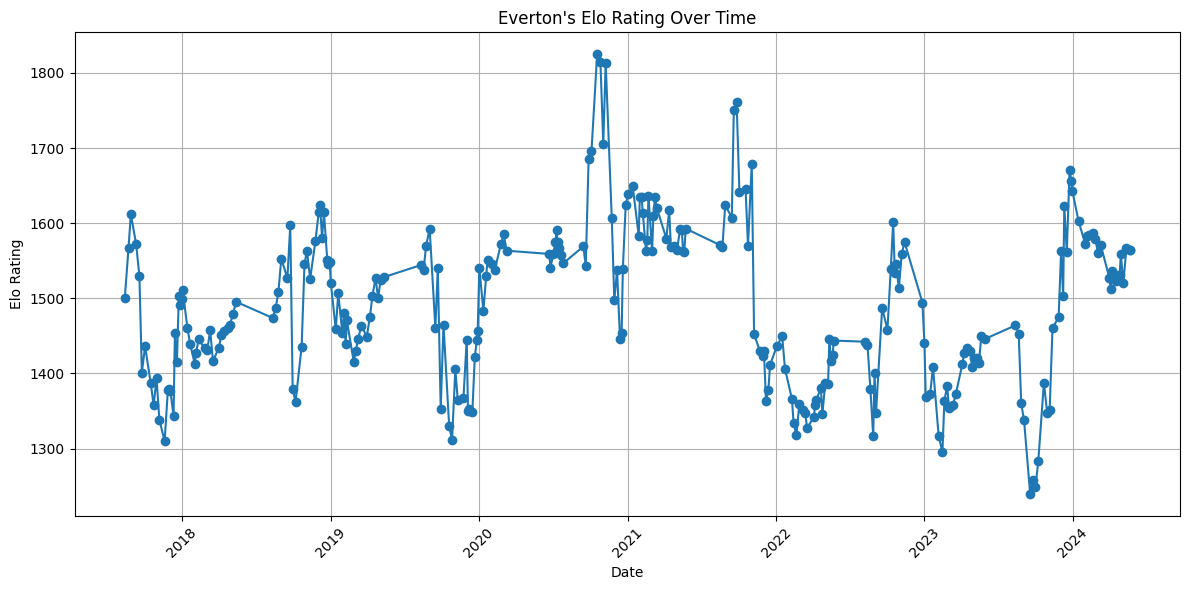

In [8]:
target_team = 'Everton'
target_home = df[df['HomeTeam'] == target_team]
target_away = df[df['AwayTeam'] == target_team]
df_target = pd.concat([target_home, target_away], ignore_index=True)

elo_dates = []
elo_ratings = []
current_elo = None
# Iterate over the matches
for index, row in df_target.iterrows():
    match_date = row['DateTime']
    if row['HomeTeam'] == target_team:
        old_elo = row['Home_Old_Elo']
        new_elo = row['Home_New_Elo']
    else:
        old_elo = row['Away_Old_Elo']
        new_elo = row['Away_New_Elo']
    if current_elo is None:
        current_elo = old_elo
    elo_dates.append(match_date)
    elo_ratings.append(current_elo)
    current_elo = new_elo

# Add the final Elo rating after the last match
elo_dates.append(match_date)
elo_ratings.append(current_elo)
elo_series = pd.Series(elo_ratings, index=elo_dates)
elo_series.sort_index(inplace=True)
plt.figure(figsize=(12, 6))
plt.plot(elo_series.index, elo_series.values, marker='o', linestyle='-')
plt.title(f"{target_team}'s Elo Rating Over Time")
plt.xlabel('Date')
plt.ylabel('Elo Rating')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


### Rivalry stats



In [9]:
df.columns

Index(['MatchID', 'Season', 'HomeTeam', 'AwayTeam', 'HomeScore', 'AwayScore',
       'TotalGoals', 'Result', 'HomeCornerKicks', 'AwayCornerKicks',
       'HomeYellowCards', 'AwayYellowCards', 'HomeShots', 'AwayShots',
       'HomeShotsOnGoal', 'AwayShotsOnGoal', 'HomeAttacks', 'AwayAttacks',
       'HomeDangerousAttacks', 'AwayDangerousAttacks', 'HomeShotsOffGoal',
       'AwayShotsOffGoal', 'HomeBlocked', 'AwayBlocked', 'HomeFreeKicks',
       'AwayFreeKicks', 'HomePossession', 'AwayPossession', 'HomePasses',
       'AwayPasses', 'HomeSuccessfulPassesPct', 'AwaySuccessfulPassesPct',
       'HomeFouls', 'AwayFouls', 'HomeOffsides', 'AwayOffsides',
       'HomeAerialsWon', 'AwayAerialsWon', 'HomeSaves', 'AwaySaves',
       'HomeTackles', 'AwayTackles', 'HomeDribbles', 'AwayDribbles',
       'HomeThrowIns', 'AwayThrowIns', 'HomeHitThePost', 'AwayHitThePost',
       'HomeSubstitutions', 'AwaySubstitutions', 'HomeRedCards',
       'AwayRedCards', 'HomeSuccessfulTackles', 'AwaySuccessfulTac

In [10]:
target_stats = ['ShotsOffGoal', 'Blocked', 'ShotsOnGoal', 'Substitutions', 'Assists', 
                'Possession', 'YellowCards', 'Offsides', 'Attacks', 'FreeKicks', 
                'SuccessfulPassesPct', 'DangerousAttacks', 'CornerKicks', 'RedCards', 
                'Dribbles', 'Tackles', 'Fouls', 'Saves', 'Shots', 'HitThePost', 'Score',
                'Interceptions', 'AerialsWon', 'ThrowIns', 'Passes', 'SuccessfulTackles']
rivalry_df = fb.calculate_rivalry_statistics(df,target_stats)
rivalry_df

,MatchID,Season,HomeTeam,AwayTeam,HomeScore,AwayScore,TotalGoals,Result,HomeCornerKicks,AwayCornerKicks,...,Home_Rivalry_Interceptions,Away_Rivalry_Interceptions,Home_Rivalry_AerialsWon,Away_Rivalry_AerialsWon,Home_Rivalry_ThrowIns,Away_Rivalry_ThrowIns,Home_Rivalry_Passes,Away_Rivalry_Passes,Home_Rivalry_SuccessfulTackles,Away_Rivalry_SuccessfulTackles
0,1394661,2017-2018,Arsenal,Leicester City,4,3,7,H,9,4,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1394670,2017-2018,Watford,Liverpool,3,3,6,D,3,3,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1394663,2017-2018,Chelsea,Burnley,2,3,5,A,8,5,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1394664,2017-2018,Crystal Palace,Huddersfield Town,0,3,3,A,12,9,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1394665,2017-2018,Everton,Stoke City,1,0,1,H,6,6,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2655,2399429,2023-2024,Brighton Hove Albion,Manchester United,0,2,2,A,7,5,...,9.615385,6.538462,10.538462,12.384615,17.461538,17.846154,422.538462,520.538462,12.461538,12.153846
2656,2399434,2023-2024,Luton Town,Fulham,2,4,6,A,4,4,...,11.000000,7.000000,19.000000,12.000000,18.000000,23.000000,222.000000,809.000000,20.000000,17.000000
2657,2399428,2023-2024,Brentford,Newcastle United,2,4,6,A,3,0,...,9.000000,7.000000,18.200000,21.000000,18.600000,23.000000,318.600000,424.600000,17.400000,14.400000
2658,2399436,2023-2024,Sheffield United,Tottenham Hotspur,0,3,3,A,2,6,...,11.600000,9.000000,18.200000,16.600000,16.800000,22.200000,342.400000,623.200000,20.000000,15.400000


In [11]:
# Forward bias checkings
team_1 = 'Manchester United'
team_2 = 'Brighton Hove Albion'
team1_2 = rivalry_df[((rivalry_df['HomeTeam'] == team_1) & (rivalry_df['AwayTeam'] == team_2)) |
                     ((rivalry_df['HomeTeam'] == team_2) & (rivalry_df['AwayTeam'] == team_1))]

team1_2[['DateTime', 'HomeTeam', 'AwayTeam','HomeScore', 'AwayScore',
        'Home_Rivalry_Score', 'Away_Rivalry_Score']]

,DateTime,HomeTeam,AwayTeam,HomeScore,AwayScore,Home_Rivalry_Score,Away_Rivalry_Score
124,2017-11-25 23:00:00,Manchester United,Brighton Hove Albion,1,0,0.000000,0.000000
354,2018-05-05 03:00:00,Brighton Hove Albion,Manchester United,1,0,0.000000,1.000000
398,2018-08-19 23:00:00,Brighton Hove Albion,Manchester United,3,2,0.500000,0.500000
603,2019-01-19 23:00:00,Manchester United,Brighton Hove Albion,2,1,1.000000,1.333333
877,2019-11-10 22:00:00,Manchester United,Brighton Hove Albion,3,1,1.250000,1.250000
1073,2020-07-01 03:15:00,Brighton Hove Albion,Manchester United,0,3,1.200000,1.600000
1158,2020-09-26 19:30:00,Brighton Hove Albion,Manchester United,2,3,1.000000,1.833333
1437,2021-04-05 02:30:00,Manchester United,Brighton Hove Albion,2,1,2.000000,1.142857
1753,2022-02-16 04:15:00,Manchester United,Brighton Hove Albion,2,0,2.000000,1.125000
1866,2022-05-08 00:30:00,Brighton Hove Albion,Manchester United,4,0,1.000000,2.000000


In [12]:
df_column = rivalry_df.columns.tolist()
# df_column

In [13]:
df = rivalry_df.copy()

In [14]:
feature_columns = ['HomeTeam_encoded', 'AwayTeam_encoded', 'ExpectedHomeScore', 'ExpectedAwayScore', 'Home_Old_Elo', 
                    'Away_Old_Elo', 'Home_Rivalry_ShotsOffGoal', 'Away_Rivalry_ShotsOffGoal', 'Home_Rivalry_Blocked', 
                    'Away_Rivalry_Blocked', 'Home_Rivalry_ShotsOnGoal', 'Away_Rivalry_ShotsOnGoal', 'Home_Rivalry_Substitutions', 
                    'Away_Rivalry_Substitutions', 'Home_Rivalry_Assists', 'Away_Rivalry_Assists', 'Home_Rivalry_Possession', 
                    'Away_Rivalry_Possession', 'Home_Rivalry_YellowCards', 'Away_Rivalry_YellowCards', 'Home_Rivalry_Offsides', 
                    'Away_Rivalry_Offsides', 'Home_Rivalry_Attacks', 'Away_Rivalry_Attacks', 'Home_Rivalry_FreeKicks', 
                    'Away_Rivalry_FreeKicks', 'Home_Rivalry_SuccessfulPassesPct', 'Away_Rivalry_SuccessfulPassesPct', 
                    'Home_Rivalry_DangerousAttacks', 'Away_Rivalry_DangerousAttacks', 'Home_Rivalry_CornerKicks', 
                    'Away_Rivalry_CornerKicks', 'Home_Rivalry_RedCards', 'Away_Rivalry_RedCards', 'Home_Rivalry_Dribbles', 
                    'Away_Rivalry_Dribbles', 'Home_Rivalry_Tackles', 'Away_Rivalry_Tackles', 'Home_Rivalry_Fouls', 
                    'Away_Rivalry_Fouls', 'Home_Rivalry_Saves', 'Away_Rivalry_Saves', 'Home_Rivalry_Shots', 'Away_Rivalry_Shots', 
                    'Home_Rivalry_HitThePost', 'Away_Rivalry_HitThePost', 'Home_Rivalry_Score', 'Away_Rivalry_Score', 
                    'Home_Rivalry_Interceptions', 'Away_Rivalry_Interceptions', 'Home_Rivalry_AerialsWon', 
                    'Away_Rivalry_AerialsWon', 'Home_Rivalry_ThrowIns', 'Away_Rivalry_ThrowIns', 'Home_Rivalry_Passes', 
                    'Away_Rivalry_Passes', 'Home_Rivalry_SuccessfulTackles', 'Away_Rivalry_SuccessfulTackles']

### Benchmark prediction

3 classes classification:

In [15]:
def train_random_forest(df, feature_columns):
    X = df[feature_columns]
    y = df['Result_encoded']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, shuffle=False
    )

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    return clf, X_test, y_test

df, team_encoder, result_encoder = fb.LE_categorical(df)

# Train the model
clf, X_test, y_test = train_random_forest(df, feature_columns)
fb.evaluate_model(clf, X_test, y_test, result_encoder)
accuracy_1 = clf.score(X_test, y_test)
print(f"Model Accuracy After Remove Features: {accuracy_1*100:.4f}%")

Classification Report:
              precision    recall  f1-score   support

           A       0.48      0.58      0.52       211
           D       0.12      0.03      0.05       142
           H       0.58      0.71      0.64       312

    accuracy                           0.52       665
   macro avg       0.40      0.44      0.40       665
weighted avg       0.45      0.52      0.48       665

Confusion Matrix:
[[122  12  77]
 [ 57   4  81]
 [ 75  16 221]]
Model Accuracy After Remove Features: 52.1805%


In [16]:
importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)


                             Feature  Importance
2                  ExpectedHomeScore    0.065057
3                  ExpectedAwayScore    0.063667
5                       Away_Old_Elo    0.052077
4                       Home_Old_Elo    0.046055
0                   HomeTeam_encoded    0.037747
1                   AwayTeam_encoded    0.034840
55               Away_Rivalry_Passes    0.021187
54               Home_Rivalry_Passes    0.019931
16           Home_Rivalry_Possession    0.018894
26  Home_Rivalry_SuccessfulPassesPct    0.018493
17           Away_Rivalry_Possession    0.018206
27  Away_Rivalry_SuccessfulPassesPct    0.017233
23              Away_Rivalry_Attacks    0.017008
35             Away_Rivalry_Dribbles    0.016951
22              Home_Rivalry_Attacks    0.016725
28     Home_Rivalry_DangerousAttacks    0.016541
50           Home_Rivalry_AerialsWon    0.015975
42                Home_Rivalry_Shots    0.015860
29     Away_Rivalry_DangerousAttacks    0.015631
11          Away_Riv

In [17]:
original_length = len(feature_importance_df)

In [18]:
# Remove less than 1 percent
print(f'Original number of features: {original_length}')
feature_importance_df = feature_importance_df[feature_importance_df['Importance'] > 0.01]
reduced_feature_columns = feature_importance_df['Feature'].tolist()
print(f'Number of features after removal: {len(feature_importance_df)}')
print(f'Proportions of features removed: {(1-(len(reduced_feature_columns)/original_length)):.2f}')

Original number of features: 58
Number of features after removal: 48
Proportions of features removed: 0.17


In [19]:
clf, X_test, y_test = train_random_forest(df, reduced_feature_columns)
fb.evaluate_model(clf, X_test, y_test, result_encoder)
accuracy_2 = clf.score(X_test, y_test)
print(f"Model Accuracy After Remove Features: {accuracy_2*100:.4f}%")

Classification Report:
              precision    recall  f1-score   support

           A       0.52      0.59      0.55       211
           D       0.38      0.09      0.15       142
           H       0.58      0.73      0.65       312

    accuracy                           0.55       665
   macro avg       0.49      0.47      0.45       665
weighted avg       0.52      0.55      0.51       665

Confusion Matrix:
[[124   4  83]
 [ 46  13  83]
 [ 67  17 228]]
Model Accuracy After Remove Features: 54.8872%


### Optimization (for 3 classes)

- Depends which class is more importance
    - if we want to predict for correct bet, we should focus on binary class and use precision(quality over quantity) as metric
    - If all 3 classes are equally important, then we should use f1 score

In [20]:
df, team_encoder, result_encoder = fb.LE_categorical(df)
X = df[reduced_feature_columns]
y = df['Result_encoded']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, shuffle=False
)

# Create and run the Optuna study
study = optuna.create_study(direction='minimize', study_name='RandomForest Optimization (F1)')
study.optimize(lambda trial: fb.optuna_objective_F1(trial, X_train, y_train, n_splits=3), n_trials=200)

# Get the best hyperparameters
print("Best Trial:")
trial = study.best_trial
print(f"  Value (Negative Mean Accuracy): {trial.value}")
print(f"  Mean Accuracy: {-trial.value}") 
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2024-09-30 00:03:59,923] A new study created in memory with name: RandomForest Optimization (F1)


Trial 0 - Fold 1
Trial 0 - Fold 2
Trial 0 - Fold 3


[I 2024-09-30 00:04:19,130] Trial 0 finished with value: -0.37706267982038133 and parameters: {'n_estimators': 4800, 'max_depth': 60, 'min_samples_split': 50, 'min_samples_leaf': 75, 'max_features': 'sqrt', 'class_weight': None}. Best is trial 0 with value: -0.37706267982038133.


Trial 1 - Fold 1
Trial 1 - Fold 2
Trial 1 - Fold 3


[I 2024-09-30 00:04:37,482] Trial 1 finished with value: -0.3780870855144111 and parameters: {'n_estimators': 4300, 'max_depth': 5, 'min_samples_split': 82, 'min_samples_leaf': 108, 'max_features': None, 'class_weight': None}. Best is trial 1 with value: -0.3780870855144111.


Trial 2 - Fold 1
Trial 2 - Fold 2
Trial 2 - Fold 3


[I 2024-09-30 00:04:49,175] Trial 2 finished with value: -0.4490031994837364 and parameters: {'n_estimators': 3000, 'max_depth': 70, 'min_samples_split': 111, 'min_samples_leaf': 52, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 2 with value: -0.4490031994837364.


Trial 3 - Fold 1
Trial 3 - Fold 2
Trial 3 - Fold 3


[I 2024-09-30 00:05:09,215] Trial 3 finished with value: -0.38127309261717207 and parameters: {'n_estimators': 5000, 'max_depth': 100, 'min_samples_split': 115, 'min_samples_leaf': 2, 'max_features': 'log2', 'class_weight': None}. Best is trial 2 with value: -0.4490031994837364.


Trial 4 - Fold 1
Trial 4 - Fold 2
Trial 4 - Fold 3


[I 2024-09-30 00:05:28,190] Trial 4 finished with value: -0.3753246579642357 and parameters: {'n_estimators': 4700, 'max_depth': 25, 'min_samples_split': 84, 'min_samples_leaf': 61, 'max_features': 'log2', 'class_weight': None}. Best is trial 2 with value: -0.4490031994837364.


Trial 5 - Fold 1
Trial 5 - Fold 2
Trial 5 - Fold 3


[I 2024-09-30 00:05:42,449] Trial 5 finished with value: -0.44770030016887286 and parameters: {'n_estimators': 3700, 'max_depth': 30, 'min_samples_split': 117, 'min_samples_leaf': 86, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 2 with value: -0.4490031994837364.


Trial 6 - Fold 1
Trial 6 - Fold 2
Trial 6 - Fold 3


[I 2024-09-30 00:05:45,644] Trial 6 finished with value: -0.4498288420454996 and parameters: {'n_estimators': 800, 'max_depth': 85, 'min_samples_split': 117, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 6 with value: -0.4498288420454996.


Trial 7 - Fold 1
Trial 7 - Fold 2
Trial 7 - Fold 3


[I 2024-09-30 00:05:55,451] Trial 7 finished with value: -0.3779702712401802 and parameters: {'n_estimators': 2500, 'max_depth': 40, 'min_samples_split': 82, 'min_samples_leaf': 59, 'max_features': 'log2', 'class_weight': None}. Best is trial 6 with value: -0.4498288420454996.


Trial 8 - Fold 1
Trial 8 - Fold 2
Trial 8 - Fold 3


[I 2024-09-30 00:06:03,650] Trial 8 finished with value: -0.38072425952491856 and parameters: {'n_estimators': 2100, 'max_depth': 130, 'min_samples_split': 34, 'min_samples_leaf': 25, 'max_features': 'sqrt', 'class_weight': None}. Best is trial 6 with value: -0.4498288420454996.


Trial 9 - Fold 1
Trial 9 - Fold 2
Trial 9 - Fold 3


[I 2024-09-30 00:06:11,652] Trial 9 finished with value: -0.444956979809869 and parameters: {'n_estimators': 1700, 'max_depth': 85, 'min_samples_split': 45, 'min_samples_leaf': 49, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 6 with value: -0.4498288420454996.


Trial 10 - Fold 1
Trial 10 - Fold 2
Trial 10 - Fold 3


[I 2024-09-30 00:06:14,214] Trial 10 finished with value: -0.40453992020401425 and parameters: {'n_estimators': 600, 'max_depth': 140, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 6 with value: -0.4498288420454996.


Trial 11 - Fold 1
Trial 11 - Fold 2
Trial 11 - Fold 3


[I 2024-09-30 00:06:27,244] Trial 11 finished with value: -0.45184536137068854 and parameters: {'n_estimators': 3300, 'max_depth': 100, 'min_samples_split': 102, 'min_samples_leaf': 32, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 11 with value: -0.45184536137068854.


Trial 12 - Fold 1
Trial 12 - Fold 2
Trial 12 - Fold 3


[I 2024-09-30 00:06:29,297] Trial 12 finished with value: -0.4518285916245091 and parameters: {'n_estimators': 500, 'max_depth': 110, 'min_samples_split': 97, 'min_samples_leaf': 25, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 11 with value: -0.45184536137068854.


Trial 13 - Fold 1
Trial 13 - Fold 2
Trial 13 - Fold 3


[I 2024-09-30 00:06:42,119] Trial 13 finished with value: -0.44984026465150156 and parameters: {'n_estimators': 3300, 'max_depth': 115, 'min_samples_split': 95, 'min_samples_leaf': 30, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 11 with value: -0.45184536137068854.


Trial 14 - Fold 1
Trial 14 - Fold 2
Trial 14 - Fold 3


[I 2024-09-30 00:06:48,228] Trial 14 finished with value: -0.44634356069051556 and parameters: {'n_estimators': 1500, 'max_depth': 110, 'min_samples_split': 70, 'min_samples_leaf': 25, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 11 with value: -0.45184536137068854.


Trial 15 - Fold 1
Trial 15 - Fold 2
Trial 15 - Fold 3


[I 2024-09-30 00:07:02,943] Trial 15 finished with value: -0.450855530292755 and parameters: {'n_estimators': 3800, 'max_depth': 150, 'min_samples_split': 98, 'min_samples_leaf': 37, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 11 with value: -0.45184536137068854.


Trial 16 - Fold 1
Trial 16 - Fold 2
Trial 16 - Fold 3


[I 2024-09-30 00:07:07,694] Trial 16 finished with value: -0.44919430483038486 and parameters: {'n_estimators': 1200, 'max_depth': 125, 'min_samples_split': 100, 'min_samples_leaf': 17, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 11 with value: -0.45184536137068854.


Trial 17 - Fold 1
Trial 17 - Fold 2
Trial 17 - Fold 3


[I 2024-09-30 00:07:20,918] Trial 17 finished with value: -0.44688412292065455 and parameters: {'n_estimators': 2500, 'max_depth': 100, 'min_samples_split': 63, 'min_samples_leaf': 17, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 11 with value: -0.45184536137068854.


Trial 18 - Fold 1
Trial 18 - Fold 2
Trial 18 - Fold 3


[I 2024-09-30 00:07:28,720] Trial 18 finished with value: -0.45136706789838543 and parameters: {'n_estimators': 2000, 'max_depth': 60, 'min_samples_split': 72, 'min_samples_leaf': 41, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 11 with value: -0.45184536137068854.


Trial 19 - Fold 1
Trial 19 - Fold 2
Trial 19 - Fold 3


[I 2024-09-30 00:07:41,913] Trial 19 finished with value: -0.44828125773657995 and parameters: {'n_estimators': 3400, 'max_depth': 95, 'min_samples_split': 101, 'min_samples_leaf': 73, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 11 with value: -0.45184536137068854.


Trial 20 - Fold 1
Trial 20 - Fold 2
Trial 20 - Fold 3


[I 2024-09-30 00:07:59,908] Trial 20 finished with value: -0.4251172639811381 and parameters: {'n_estimators': 4200, 'max_depth': 120, 'min_samples_split': 21, 'min_samples_leaf': 117, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 11 with value: -0.45184536137068854.


Trial 21 - Fold 1
Trial 21 - Fold 2
Trial 21 - Fold 3


[I 2024-09-30 00:08:04,277] Trial 21 finished with value: -0.4525167519867357 and parameters: {'n_estimators': 1100, 'max_depth': 55, 'min_samples_split': 71, 'min_samples_leaf': 40, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 21 with value: -0.4525167519867357.


Trial 22 - Fold 1
Trial 22 - Fold 2
Trial 22 - Fold 3


[I 2024-09-30 00:08:08,233] Trial 22 finished with value: -0.45130860663958106 and parameters: {'n_estimators': 1000, 'max_depth': 50, 'min_samples_split': 89, 'min_samples_leaf': 40, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 21 with value: -0.4525167519867357.


Trial 23 - Fold 1
Trial 23 - Fold 2
Trial 23 - Fold 3


[I 2024-09-30 00:08:10,305] Trial 23 finished with value: -0.4478185254692764 and parameters: {'n_estimators': 500, 'max_depth': 75, 'min_samples_split': 73, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 21 with value: -0.4525167519867357.


Trial 24 - Fold 1
Trial 24 - Fold 2
Trial 24 - Fold 3


[I 2024-09-30 00:08:15,037] Trial 24 finished with value: -0.4523237308186443 and parameters: {'n_estimators': 1200, 'max_depth': 90, 'min_samples_split': 106, 'min_samples_leaf': 34, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 21 with value: -0.4525167519867357.


Trial 25 - Fold 1
Trial 25 - Fold 2
Trial 25 - Fold 3


[I 2024-09-30 00:08:21,102] Trial 25 finished with value: -0.4516567062426522 and parameters: {'n_estimators': 1500, 'max_depth': 65, 'min_samples_split': 109, 'min_samples_leaf': 47, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 21 with value: -0.4525167519867357.


Trial 26 - Fold 1
Trial 26 - Fold 2
Trial 26 - Fold 3


[I 2024-09-30 00:08:31,675] Trial 26 finished with value: -0.453406706734874 and parameters: {'n_estimators': 2700, 'max_depth': 90, 'min_samples_split': 56, 'min_samples_leaf': 36, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 26 with value: -0.453406706734874.


Trial 27 - Fold 1
Trial 27 - Fold 2
Trial 27 - Fold 3


[I 2024-09-30 00:08:36,383] Trial 27 finished with value: -0.4413909328502294 and parameters: {'n_estimators': 1200, 'max_depth': 85, 'min_samples_split': 52, 'min_samples_leaf': 61, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 26 with value: -0.453406706734874.


Trial 28 - Fold 1
Trial 28 - Fold 2
Trial 28 - Fold 3


[I 2024-09-30 00:08:45,509] Trial 28 finished with value: -0.4422222083366827 and parameters: {'n_estimators': 2000, 'max_depth': 50, 'min_samples_split': 37, 'min_samples_leaf': 69, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 26 with value: -0.453406706734874.


Trial 29 - Fold 1
Trial 29 - Fold 2
Trial 29 - Fold 3


[I 2024-09-30 00:08:55,639] Trial 29 finished with value: -0.37449210981840547 and parameters: {'n_estimators': 2600, 'max_depth': 50, 'min_samples_split': 56, 'min_samples_leaf': 91, 'max_features': 'sqrt', 'class_weight': None}. Best is trial 26 with value: -0.453406706734874.


Trial 30 - Fold 1
Trial 30 - Fold 2
Trial 30 - Fold 3


[I 2024-09-30 00:09:04,114] Trial 30 finished with value: -0.4504395213517019 and parameters: {'n_estimators': 2200, 'max_depth': 80, 'min_samples_split': 63, 'min_samples_leaf': 45, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 26 with value: -0.453406706734874.


Trial 31 - Fold 1
Trial 31 - Fold 2
Trial 31 - Fold 3


[I 2024-09-30 00:09:16,056] Trial 31 finished with value: -0.4497927177977659 and parameters: {'n_estimators': 3100, 'max_depth': 95, 'min_samples_split': 43, 'min_samples_leaf': 33, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 26 with value: -0.453406706734874.


Trial 32 - Fold 1
Trial 32 - Fold 2
Trial 32 - Fold 3


[I 2024-09-30 00:09:30,440] Trial 32 finished with value: -0.45152153765333897 and parameters: {'n_estimators': 3700, 'max_depth': 75, 'min_samples_split': 107, 'min_samples_leaf': 33, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 26 with value: -0.453406706734874.


Trial 33 - Fold 1
Trial 33 - Fold 2
Trial 33 - Fold 3


[I 2024-09-30 00:09:41,783] Trial 33 finished with value: -0.45101568442768025 and parameters: {'n_estimators': 2900, 'max_depth': 10, 'min_samples_split': 89, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 26 with value: -0.453406706734874.


Trial 34 - Fold 1
Trial 34 - Fold 2
Trial 34 - Fold 3


[I 2024-09-30 00:09:58,110] Trial 34 finished with value: -0.37827346908148174 and parameters: {'n_estimators': 4200, 'max_depth': 105, 'min_samples_split': 77, 'min_samples_leaf': 53, 'max_features': 'sqrt', 'class_weight': None}. Best is trial 26 with value: -0.453406706734874.


Trial 35 - Fold 1
Trial 35 - Fold 2
Trial 35 - Fold 3


[I 2024-09-30 00:10:03,921] Trial 35 finished with value: -0.4473453453385234 and parameters: {'n_estimators': 1500, 'max_depth': 90, 'min_samples_split': 58, 'min_samples_leaf': 56, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 26 with value: -0.453406706734874.


Trial 36 - Fold 1
Trial 36 - Fold 2
Trial 36 - Fold 3


[I 2024-09-30 00:10:07,504] Trial 36 finished with value: -0.4485260368367743 and parameters: {'n_estimators': 900, 'max_depth': 65, 'min_samples_split': 106, 'min_samples_leaf': 13, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 26 with value: -0.453406706734874.


Trial 37 - Fold 1
Trial 37 - Fold 2
Trial 37 - Fold 3


[I 2024-09-30 00:10:24,851] Trial 37 finished with value: -0.3784451225256665 and parameters: {'n_estimators': 4500, 'max_depth': 70, 'min_samples_split': 26, 'min_samples_leaf': 42, 'max_features': 'log2', 'class_weight': None}. Best is trial 26 with value: -0.453406706734874.


Trial 38 - Fold 1
Trial 38 - Fold 2
Trial 38 - Fold 3


[I 2024-09-30 00:10:33,683] Trial 38 finished with value: -0.4526823366887765 and parameters: {'n_estimators': 1800, 'max_depth': 40, 'min_samples_split': 119, 'min_samples_leaf': 32, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 26 with value: -0.453406706734874.


Trial 39 - Fold 1
Trial 39 - Fold 2
Trial 39 - Fold 3


[I 2024-09-30 00:10:42,087] Trial 39 finished with value: -0.3720938764310872 and parameters: {'n_estimators': 1800, 'max_depth': 35, 'min_samples_split': 120, 'min_samples_leaf': 64, 'max_features': None, 'class_weight': None}. Best is trial 26 with value: -0.453406706734874.


Trial 40 - Fold 1
Trial 40 - Fold 2
Trial 40 - Fold 3


[I 2024-09-30 00:10:47,767] Trial 40 finished with value: -0.44754263438492115 and parameters: {'n_estimators': 1200, 'max_depth': 20, 'min_samples_split': 111, 'min_samples_leaf': 51, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 26 with value: -0.453406706734874.


Trial 41 - Fold 1
Trial 41 - Fold 2
Trial 41 - Fold 3


[I 2024-09-30 00:10:58,943] Trial 41 finished with value: -0.44906961270837126 and parameters: {'n_estimators': 2300, 'max_depth': 40, 'min_samples_split': 87, 'min_samples_leaf': 30, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 26 with value: -0.453406706734874.


Trial 42 - Fold 1
Trial 42 - Fold 2
Trial 42 - Fold 3


[I 2024-09-30 00:11:07,064] Trial 42 finished with value: -0.4509083876088536 and parameters: {'n_estimators': 1700, 'max_depth': 55, 'min_samples_split': 114, 'min_samples_leaf': 34, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 26 with value: -0.453406706734874.


Trial 43 - Fold 1
Trial 43 - Fold 2
Trial 43 - Fold 3


[I 2024-09-30 00:11:17,773] Trial 43 finished with value: -0.4523831385233326 and parameters: {'n_estimators': 2800, 'max_depth': 40, 'min_samples_split': 120, 'min_samples_leaf': 9, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 26 with value: -0.453406706734874.


Trial 44 - Fold 1
Trial 44 - Fold 2
Trial 44 - Fold 3


[I 2024-09-30 00:11:28,372] Trial 44 finished with value: -0.45284233143855435 and parameters: {'n_estimators': 2700, 'max_depth': 20, 'min_samples_split': 120, 'min_samples_leaf': 9, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 26 with value: -0.453406706734874.


Trial 45 - Fold 1
Trial 45 - Fold 2
Trial 45 - Fold 3


[I 2024-09-30 00:11:39,100] Trial 45 finished with value: -0.4518665506233332 and parameters: {'n_estimators': 2800, 'max_depth': 15, 'min_samples_split': 116, 'min_samples_leaf': 11, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 26 with value: -0.453406706734874.


Trial 46 - Fold 1
Trial 46 - Fold 2
Trial 46 - Fold 3


[I 2024-09-30 00:11:49,909] Trial 46 finished with value: -0.44346067313128373 and parameters: {'n_estimators': 2700, 'max_depth': 30, 'min_samples_split': 46, 'min_samples_leaf': 6, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 26 with value: -0.453406706734874.


Trial 47 - Fold 1
Trial 47 - Fold 2
Trial 47 - Fold 3


[I 2024-09-30 00:11:59,513] Trial 47 finished with value: -0.45296796463735717 and parameters: {'n_estimators': 2400, 'max_depth': 40, 'min_samples_split': 120, 'min_samples_leaf': 24, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 26 with value: -0.453406706734874.


Trial 48 - Fold 1
Trial 48 - Fold 2
Trial 48 - Fold 3


[I 2024-09-30 00:12:08,843] Trial 48 finished with value: -0.3788158420340901 and parameters: {'n_estimators': 2400, 'max_depth': 25, 'min_samples_split': 92, 'min_samples_leaf': 23, 'max_features': 'log2', 'class_weight': None}. Best is trial 26 with value: -0.453406706734874.


Trial 49 - Fold 1
Trial 49 - Fold 2
Trial 49 - Fold 3


[I 2024-09-30 00:12:20,468] Trial 49 finished with value: -0.4495586633855828 and parameters: {'n_estimators': 3000, 'max_depth': 5, 'min_samples_split': 78, 'min_samples_leaf': 16, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 26 with value: -0.453406706734874.


Trial 50 - Fold 1
Trial 50 - Fold 2
Trial 50 - Fold 3


[I 2024-09-30 00:12:28,662] Trial 50 finished with value: -0.45357153562855385 and parameters: {'n_estimators': 2100, 'max_depth': 30, 'min_samples_split': 113, 'min_samples_leaf': 27, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 50 with value: -0.45357153562855385.


Trial 51 - Fold 1
Trial 51 - Fold 2
Trial 51 - Fold 3


[I 2024-09-30 00:12:36,078] Trial 51 finished with value: -0.45570234267629545 and parameters: {'n_estimators': 1900, 'max_depth': 30, 'min_samples_split': 113, 'min_samples_leaf': 26, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 52 - Fold 1
Trial 52 - Fold 2
Trial 52 - Fold 3


[I 2024-09-30 00:12:43,448] Trial 52 finished with value: -0.453648175326599 and parameters: {'n_estimators': 1900, 'max_depth': 20, 'min_samples_split': 111, 'min_samples_leaf': 28, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 53 - Fold 1
Trial 53 - Fold 2
Trial 53 - Fold 3


[I 2024-09-30 00:12:52,259] Trial 53 finished with value: -0.4534756496544518 and parameters: {'n_estimators': 2200, 'max_depth': 20, 'min_samples_split': 111, 'min_samples_leaf': 23, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 54 - Fold 1
Trial 54 - Fold 2
Trial 54 - Fold 3


[I 2024-09-30 00:13:00,380] Trial 54 finished with value: -0.45468972094364185 and parameters: {'n_estimators': 2100, 'max_depth': 30, 'min_samples_split': 114, 'min_samples_leaf': 26, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 55 - Fold 1
Trial 55 - Fold 2
Trial 55 - Fold 3


[I 2024-09-30 00:13:08,110] Trial 55 finished with value: -0.4541962460737465 and parameters: {'n_estimators': 2000, 'max_depth': 30, 'min_samples_split': 113, 'min_samples_leaf': 28, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 56 - Fold 1
Trial 56 - Fold 2
Trial 56 - Fold 3


[I 2024-09-30 00:13:16,363] Trial 56 finished with value: -0.45331148146981276 and parameters: {'n_estimators': 2100, 'max_depth': 30, 'min_samples_split': 112, 'min_samples_leaf': 28, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 57 - Fold 1
Trial 57 - Fold 2
Trial 57 - Fold 3


[I 2024-09-30 00:13:23,761] Trial 57 finished with value: -0.4500614222262019 and parameters: {'n_estimators': 1900, 'max_depth': 15, 'min_samples_split': 103, 'min_samples_leaf': 19, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 58 - Fold 1
Trial 58 - Fold 2
Trial 58 - Fold 3


[I 2024-09-30 00:13:30,063] Trial 58 finished with value: -0.45238977242770567 and parameters: {'n_estimators': 1600, 'max_depth': 25, 'min_samples_split': 96, 'min_samples_leaf': 28, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 59 - Fold 1
Trial 59 - Fold 2
Trial 59 - Fold 3


[I 2024-09-30 00:13:38,677] Trial 59 finished with value: -0.45368378161953404 and parameters: {'n_estimators': 2200, 'max_depth': 10, 'min_samples_split': 103, 'min_samples_leaf': 22, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 60 - Fold 1
Trial 60 - Fold 2
Trial 60 - Fold 3


[I 2024-09-30 00:13:44,239] Trial 60 finished with value: -0.44959983444099866 and parameters: {'n_estimators': 1400, 'max_depth': 5, 'min_samples_split': 103, 'min_samples_leaf': 14, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 61 - Fold 1
Trial 61 - Fold 2
Trial 61 - Fold 3


[I 2024-09-30 00:13:52,606] Trial 61 finished with value: -0.45464141742945885 and parameters: {'n_estimators': 2100, 'max_depth': 15, 'min_samples_split': 114, 'min_samples_leaf': 22, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 62 - Fold 1
Trial 62 - Fold 2
Trial 62 - Fold 3


[I 2024-09-30 00:14:00,567] Trial 62 finished with value: -0.4549177596789729 and parameters: {'n_estimators': 2000, 'max_depth': 10, 'min_samples_split': 116, 'min_samples_leaf': 20, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 63 - Fold 1
Trial 63 - Fold 2
Trial 63 - Fold 3


[I 2024-09-30 00:14:07,988] Trial 63 finished with value: -0.45103065944074455 and parameters: {'n_estimators': 1900, 'max_depth': 10, 'min_samples_split': 108, 'min_samples_leaf': 20, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 64 - Fold 1
Trial 64 - Fold 2
Trial 64 - Fold 3


[I 2024-09-30 00:14:17,054] Trial 64 finished with value: -0.4529762539567332 and parameters: {'n_estimators': 2300, 'max_depth': 10, 'min_samples_split': 114, 'min_samples_leaf': 2, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 65 - Fold 1
Trial 65 - Fold 2
Trial 65 - Fold 3


[I 2024-09-30 00:14:26,899] Trial 65 finished with value: -0.4523218442703644 and parameters: {'n_estimators': 2500, 'max_depth': 15, 'min_samples_split': 99, 'min_samples_leaf': 38, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 66 - Fold 1
Trial 66 - Fold 2
Trial 66 - Fold 3


[I 2024-09-30 00:14:34,729] Trial 66 finished with value: -0.4529143731521021 and parameters: {'n_estimators': 2000, 'max_depth': 25, 'min_samples_split': 104, 'min_samples_leaf': 21, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 67 - Fold 1
Trial 67 - Fold 2
Trial 67 - Fold 3


[I 2024-09-30 00:14:41,317] Trial 67 finished with value: -0.4461092111299611 and parameters: {'n_estimators': 1700, 'max_depth': 5, 'min_samples_split': 116, 'min_samples_leaf': 93, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 68 - Fold 1
Trial 68 - Fold 2
Trial 68 - Fold 3


[I 2024-09-30 00:14:48,764] Trial 68 finished with value: -0.38145295874200036 and parameters: {'n_estimators': 1900, 'max_depth': 35, 'min_samples_split': 94, 'min_samples_leaf': 15, 'max_features': 'log2', 'class_weight': None}. Best is trial 51 with value: -0.45570234267629545.


Trial 69 - Fold 1
Trial 69 - Fold 2
Trial 69 - Fold 3


[I 2024-09-30 00:14:57,562] Trial 69 finished with value: -0.4522146819248345 and parameters: {'n_estimators': 2200, 'max_depth': 15, 'min_samples_split': 109, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 70 - Fold 1
Trial 70 - Fold 2
Trial 70 - Fold 3


[I 2024-09-30 00:15:03,053] Trial 70 finished with value: -0.4513279371910575 and parameters: {'n_estimators': 1400, 'max_depth': 20, 'min_samples_split': 100, 'min_samples_leaf': 44, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 71 - Fold 1
Trial 71 - Fold 2
Trial 71 - Fold 3


[I 2024-09-30 00:15:11,274] Trial 71 finished with value: -0.4544289532090186 and parameters: {'n_estimators': 2100, 'max_depth': 35, 'min_samples_split': 113, 'min_samples_leaf': 28, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 72 - Fold 1
Trial 72 - Fold 2
Trial 72 - Fold 3


[I 2024-09-30 00:15:20,217] Trial 72 finished with value: -0.4528495061032272 and parameters: {'n_estimators': 2300, 'max_depth': 35, 'min_samples_split': 116, 'min_samples_leaf': 27, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 73 - Fold 1
Trial 73 - Fold 2
Trial 73 - Fold 3


[I 2024-09-30 00:15:27,484] Trial 73 finished with value: -0.4480649068461296 and parameters: {'n_estimators': 1800, 'max_depth': 45, 'min_samples_split': 110, 'min_samples_leaf': 19, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 74 - Fold 1
Trial 74 - Fold 2
Trial 74 - Fold 3


[I 2024-09-30 00:15:35,729] Trial 74 finished with value: -0.45391533889124563 and parameters: {'n_estimators': 2100, 'max_depth': 10, 'min_samples_split': 105, 'min_samples_leaf': 37, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 75 - Fold 1
Trial 75 - Fold 2
Trial 75 - Fold 3


[I 2024-09-30 00:15:43,941] Trial 75 finished with value: -0.45391533889124563 and parameters: {'n_estimators': 2100, 'max_depth': 10, 'min_samples_split': 105, 'min_samples_leaf': 37, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 76 - Fold 1
Trial 76 - Fold 2
Trial 76 - Fold 3


[I 2024-09-30 00:15:53,696] Trial 76 finished with value: -0.45054401352613277 and parameters: {'n_estimators': 2500, 'max_depth': 25, 'min_samples_split': 106, 'min_samples_leaf': 36, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 77 - Fold 1
Trial 77 - Fold 2
Trial 77 - Fold 3


[I 2024-09-30 00:16:00,104] Trial 77 finished with value: -0.4533725454702007 and parameters: {'n_estimators': 1600, 'max_depth': 5, 'min_samples_split': 117, 'min_samples_leaf': 38, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 78 - Fold 1
Trial 78 - Fold 2
Trial 78 - Fold 3


[I 2024-09-30 00:16:08,347] Trial 78 finished with value: -0.4515361420348862 and parameters: {'n_estimators': 2100, 'max_depth': 15, 'min_samples_split': 106, 'min_samples_leaf': 31, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 79 - Fold 1
Trial 79 - Fold 2
Trial 79 - Fold 3


[I 2024-09-30 00:16:17,694] Trial 79 finished with value: -0.378155505276441 and parameters: {'n_estimators': 2400, 'max_depth': 45, 'min_samples_split': 8, 'min_samples_leaf': 46, 'max_features': 'log2', 'class_weight': None}. Best is trial 51 with value: -0.45570234267629545.


Trial 80 - Fold 1
Trial 80 - Fold 2
Trial 80 - Fold 3


[I 2024-09-30 00:16:25,485] Trial 80 finished with value: -0.4521592389132265 and parameters: {'n_estimators': 2000, 'max_depth': 35, 'min_samples_split': 114, 'min_samples_leaf': 42, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 81 - Fold 1
Trial 81 - Fold 2
Trial 81 - Fold 3


[I 2024-09-30 00:16:34,239] Trial 81 finished with value: -0.45145997281229117 and parameters: {'n_estimators': 2200, 'max_depth': 10, 'min_samples_split': 102, 'min_samples_leaf': 23, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 82 - Fold 1
Trial 82 - Fold 2
Trial 82 - Fold 3


[I 2024-09-30 00:16:42,479] Trial 82 finished with value: -0.45265955847142864 and parameters: {'n_estimators': 2100, 'max_depth': 10, 'min_samples_split': 97, 'min_samples_leaf': 25, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 83 - Fold 1
Trial 83 - Fold 2
Trial 83 - Fold 3


[I 2024-09-30 00:16:49,227] Trial 83 finished with value: -0.45168610911633517 and parameters: {'n_estimators': 1700, 'max_depth': 30, 'min_samples_split': 108, 'min_samples_leaf': 17, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 84 - Fold 1
Trial 84 - Fold 2
Trial 84 - Fold 3


[I 2024-09-30 00:16:58,088] Trial 84 finished with value: -0.44819395727302386 and parameters: {'n_estimators': 2300, 'max_depth': 15, 'min_samples_split': 117, 'min_samples_leaf': 80, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 85 - Fold 1
Trial 85 - Fold 2
Trial 85 - Fold 3


[I 2024-09-30 00:17:05,179] Trial 85 finished with value: -0.4499318699781374 and parameters: {'n_estimators': 1800, 'max_depth': 25, 'min_samples_split': 93, 'min_samples_leaf': 30, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 86 - Fold 1
Trial 86 - Fold 2
Trial 86 - Fold 3


[I 2024-09-30 00:17:15,373] Trial 86 finished with value: -0.4501966034034985 and parameters: {'n_estimators': 2600, 'max_depth': 5, 'min_samples_split': 105, 'min_samples_leaf': 35, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 87 - Fold 1
Trial 87 - Fold 2
Trial 87 - Fold 3


[I 2024-09-30 00:17:23,532] Trial 87 finished with value: -0.45173951085562947 and parameters: {'n_estimators': 2000, 'max_depth': 20, 'min_samples_split': 113, 'min_samples_leaf': 12, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 88 - Fold 1
Trial 88 - Fold 2
Trial 88 - Fold 3


[I 2024-09-30 00:17:29,306] Trial 88 finished with value: -0.4522602836226188 and parameters: {'n_estimators': 1400, 'max_depth': 10, 'min_samples_split': 100, 'min_samples_leaf': 20, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 89 - Fold 1
Trial 89 - Fold 2
Trial 89 - Fold 3


[I 2024-09-30 00:17:39,851] Trial 89 finished with value: -0.4546115447131214 and parameters: {'n_estimators': 2600, 'max_depth': 45, 'min_samples_split': 110, 'min_samples_leaf': 26, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 90 - Fold 1
Trial 90 - Fold 2
Trial 90 - Fold 3


[I 2024-09-30 00:17:49,512] Trial 90 finished with value: -0.45088278130592435 and parameters: {'n_estimators': 2400, 'max_depth': 35, 'min_samples_split': 109, 'min_samples_leaf': 39, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 91 - Fold 1
Trial 91 - Fold 2
Trial 91 - Fold 3


[I 2024-09-30 00:17:58,008] Trial 91 finished with value: -0.44953393900337696 and parameters: {'n_estimators': 2200, 'max_depth': 30, 'min_samples_split': 118, 'min_samples_leaf': 31, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 92 - Fold 1
Trial 92 - Fold 2
Trial 92 - Fold 3


[I 2024-09-30 00:18:07,655] Trial 92 finished with value: -0.45345235578469484 and parameters: {'n_estimators': 2500, 'max_depth': 45, 'min_samples_split': 112, 'min_samples_leaf': 25, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 93 - Fold 1
Trial 93 - Fold 2
Trial 93 - Fold 3


[I 2024-09-30 00:18:17,722] Trial 93 finished with value: -0.45345405928891686 and parameters: {'n_estimators': 2600, 'max_depth': 20, 'min_samples_split': 104, 'min_samples_leaf': 22, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 94 - Fold 1
Trial 94 - Fold 2
Trial 94 - Fold 3


[I 2024-09-30 00:18:23,967] Trial 94 finished with value: -0.45193506769217723 and parameters: {'n_estimators': 1600, 'max_depth': 25, 'min_samples_split': 108, 'min_samples_leaf': 49, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 95 - Fold 1
Trial 95 - Fold 2
Trial 95 - Fold 3


[I 2024-09-30 00:18:31,788] Trial 95 finished with value: -0.4554637369500294 and parameters: {'n_estimators': 2000, 'max_depth': 15, 'min_samples_split': 115, 'min_samples_leaf': 26, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 96 - Fold 1
Trial 96 - Fold 2
Trial 96 - Fold 3


[I 2024-09-30 00:18:39,229] Trial 96 finished with value: -0.45378223399230705 and parameters: {'n_estimators': 1900, 'max_depth': 55, 'min_samples_split': 115, 'min_samples_leaf': 26, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 97 - Fold 1
Trial 97 - Fold 2
Trial 97 - Fold 3


[I 2024-09-30 00:18:58,275] Trial 97 finished with value: -0.37900826795748843 and parameters: {'n_estimators': 4900, 'max_depth': 30, 'min_samples_split': 111, 'min_samples_leaf': 17, 'max_features': 'log2', 'class_weight': None}. Best is trial 51 with value: -0.45570234267629545.


Trial 98 - Fold 1
Trial 98 - Fold 2
Trial 98 - Fold 3


[I 2024-09-30 00:19:06,009] Trial 98 finished with value: -0.44921029737711954 and parameters: {'n_estimators': 2000, 'max_depth': 40, 'min_samples_split': 117, 'min_samples_leaf': 33, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 99 - Fold 1
Trial 99 - Fold 2
Trial 99 - Fold 3


[I 2024-09-30 00:19:14,217] Trial 99 finished with value: -0.4546037384234339 and parameters: {'n_estimators': 2100, 'max_depth': 20, 'min_samples_split': 120, 'min_samples_leaf': 29, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 100 - Fold 1
Trial 100 - Fold 2
Trial 100 - Fold 3


[I 2024-09-30 00:19:22,621] Trial 100 finished with value: -0.44901780639011984 and parameters: {'n_estimators': 1700, 'max_depth': 25, 'min_samples_split': 120, 'min_samples_leaf': 29, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 101 - Fold 1
Trial 101 - Fold 2
Trial 101 - Fold 3


[I 2024-09-30 00:19:30,738] Trial 101 finished with value: -0.451293620628557 and parameters: {'n_estimators': 2100, 'max_depth': 15, 'min_samples_split': 113, 'min_samples_leaf': 35, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 102 - Fold 1
Trial 102 - Fold 2
Trial 102 - Fold 3


[I 2024-09-30 00:19:39,609] Trial 102 finished with value: -0.4550978107971142 and parameters: {'n_estimators': 2300, 'max_depth': 20, 'min_samples_split': 115, 'min_samples_leaf': 26, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 103 - Fold 1
Trial 103 - Fold 2
Trial 103 - Fold 3


[I 2024-09-30 00:19:46,988] Trial 103 finished with value: -0.4526303929499845 and parameters: {'n_estimators': 1900, 'max_depth': 20, 'min_samples_split': 118, 'min_samples_leaf': 25, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 104 - Fold 1
Trial 104 - Fold 2
Trial 104 - Fold 3


[I 2024-09-30 00:19:56,443] Trial 104 finished with value: -0.4518997921791061 and parameters: {'n_estimators': 2400, 'max_depth': 30, 'min_samples_split': 115, 'min_samples_leaf': 29, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 105 - Fold 1
Trial 105 - Fold 2
Trial 105 - Fold 3


[I 2024-09-30 00:20:07,631] Trial 105 finished with value: -0.4543260533943965 and parameters: {'n_estimators': 2900, 'max_depth': 135, 'min_samples_split': 110, 'min_samples_leaf': 19, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 106 - Fold 1
Trial 106 - Fold 2
Trial 106 - Fold 3


[I 2024-09-30 00:20:16,556] Trial 106 finished with value: -0.4514703761577267 and parameters: {'n_estimators': 2300, 'max_depth': 140, 'min_samples_split': 110, 'min_samples_leaf': 18, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 107 - Fold 1
Trial 107 - Fold 2
Trial 107 - Fold 3


[I 2024-09-30 00:20:29,147] Trial 107 finished with value: -0.45337466174174706 and parameters: {'n_estimators': 3200, 'max_depth': 130, 'min_samples_split': 115, 'min_samples_leaf': 14, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 108 - Fold 1
Trial 108 - Fold 2
Trial 108 - Fold 3


[I 2024-09-30 00:20:36,136] Trial 108 finished with value: -0.45489417249539393 and parameters: {'n_estimators': 1800, 'max_depth': 145, 'min_samples_split': 120, 'min_samples_leaf': 20, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 109 - Fold 1
Trial 109 - Fold 2
Trial 109 - Fold 3


[I 2024-09-30 00:20:47,755] Trial 109 finished with value: -0.45125503986868803 and parameters: {'n_estimators': 3000, 'max_depth': 140, 'min_samples_split': 119, 'min_samples_leaf': 8, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 110 - Fold 1
Trial 110 - Fold 2
Trial 110 - Fold 3


[I 2024-09-30 00:21:01,207] Trial 110 finished with value: -0.45269143209734475 and parameters: {'n_estimators': 3500, 'max_depth': 150, 'min_samples_split': 120, 'min_samples_leaf': 21, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 111 - Fold 1
Trial 111 - Fold 2
Trial 111 - Fold 3


[I 2024-09-30 00:21:08,214] Trial 111 finished with value: -0.45428555814034777 and parameters: {'n_estimators': 1800, 'max_depth': 145, 'min_samples_split': 112, 'min_samples_leaf': 27, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 112 - Fold 1
Trial 112 - Fold 2
Trial 112 - Fold 3


[I 2024-09-30 00:21:15,210] Trial 112 finished with value: -0.4509510523089364 and parameters: {'n_estimators': 1800, 'max_depth': 140, 'min_samples_split': 111, 'min_samples_leaf': 23, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 113 - Fold 1
Trial 113 - Fold 2
Trial 113 - Fold 3


[I 2024-09-30 00:21:26,362] Trial 113 finished with value: -0.4550057990695935 and parameters: {'n_estimators': 2900, 'max_depth': 115, 'min_samples_split': 116, 'min_samples_leaf': 26, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 114 - Fold 1
Trial 114 - Fold 2
Trial 114 - Fold 3


[I 2024-09-30 00:21:37,674] Trial 114 finished with value: -0.45183511092168266 and parameters: {'n_estimators': 2900, 'max_depth': 125, 'min_samples_split': 117, 'min_samples_leaf': 15, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 115 - Fold 1
Trial 115 - Fold 2
Trial 115 - Fold 3


[I 2024-09-30 00:21:48,710] Trial 115 finished with value: -0.45491939104895535 and parameters: {'n_estimators': 2800, 'max_depth': 130, 'min_samples_split': 108, 'min_samples_leaf': 19, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 116 - Fold 1
Trial 116 - Fold 2
Trial 116 - Fold 3


[I 2024-09-30 00:21:58,886] Trial 116 finished with value: -0.3783303664493282 and parameters: {'n_estimators': 2600, 'max_depth': 110, 'min_samples_split': 67, 'min_samples_leaf': 12, 'max_features': 'log2', 'class_weight': None}. Best is trial 51 with value: -0.45570234267629545.


Trial 117 - Fold 1
Trial 117 - Fold 2
Trial 117 - Fold 3


[I 2024-09-30 00:22:09,316] Trial 117 finished with value: -0.4508061051781986 and parameters: {'n_estimators': 2700, 'max_depth': 145, 'min_samples_split': 115, 'min_samples_leaf': 32, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 118 - Fold 1
Trial 118 - Fold 2
Trial 118 - Fold 3


[I 2024-09-30 00:22:24,795] Trial 118 finished with value: -0.4501135291014271 and parameters: {'n_estimators': 3200, 'max_depth': 115, 'min_samples_split': 118, 'min_samples_leaf': 24, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 119 - Fold 1
Trial 119 - Fold 2
Trial 119 - Fold 3


[I 2024-09-30 00:22:36,387] Trial 119 finished with value: -0.4524348217453062 and parameters: {'n_estimators': 3000, 'max_depth': 125, 'min_samples_split': 108, 'min_samples_leaf': 17, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 120 - Fold 1
Trial 120 - Fold 2
Trial 120 - Fold 3


[I 2024-09-30 00:22:45,527] Trial 120 finished with value: -0.4535524608111447 and parameters: {'n_estimators': 2300, 'max_depth': 135, 'min_samples_split': 114, 'min_samples_leaf': 22, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 121 - Fold 1
Trial 121 - Fold 2
Trial 121 - Fold 3


[I 2024-09-30 00:22:56,304] Trial 121 finished with value: -0.45487158242265946 and parameters: {'n_estimators': 2800, 'max_depth': 135, 'min_samples_split': 110, 'min_samples_leaf': 19, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 51 with value: -0.45570234267629545.


Trial 122 - Fold 1
Trial 122 - Fold 2
Trial 122 - Fold 3


[I 2024-09-30 00:23:07,054] Trial 122 finished with value: -0.4569549482645559 and parameters: {'n_estimators': 2800, 'max_depth': 145, 'min_samples_split': 120, 'min_samples_leaf': 26, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 123 - Fold 1
Trial 123 - Fold 2
Trial 123 - Fold 3


[I 2024-09-30 00:23:18,028] Trial 123 finished with value: -0.4569549482645559 and parameters: {'n_estimators': 2800, 'max_depth': 135, 'min_samples_split': 120, 'min_samples_leaf': 26, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 124 - Fold 1
Trial 124 - Fold 2
Trial 124 - Fold 3


[I 2024-09-30 00:23:28,835] Trial 124 finished with value: -0.4541591099418098 and parameters: {'n_estimators': 2800, 'max_depth': 145, 'min_samples_split': 117, 'min_samples_leaf': 20, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 125 - Fold 1
Trial 125 - Fold 2
Trial 125 - Fold 3


[I 2024-09-30 00:23:40,841] Trial 125 finished with value: -0.4536923793298144 and parameters: {'n_estimators': 3100, 'max_depth': 130, 'min_samples_split': 107, 'min_samples_leaf': 15, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 126 - Fold 1
Trial 126 - Fold 2
Trial 126 - Fold 3


[I 2024-09-30 00:23:52,206] Trial 126 finished with value: -0.45534295758724636 and parameters: {'n_estimators': 2900, 'max_depth': 120, 'min_samples_split': 116, 'min_samples_leaf': 25, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 127 - Fold 1
Trial 127 - Fold 2
Trial 127 - Fold 3


[I 2024-09-30 00:24:03,408] Trial 127 finished with value: -0.453961145497028 and parameters: {'n_estimators': 2900, 'max_depth': 135, 'min_samples_split': 116, 'min_samples_leaf': 24, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 128 - Fold 1
Trial 128 - Fold 2
Trial 128 - Fold 3


[I 2024-09-30 00:24:14,220] Trial 128 finished with value: -0.4531387673819954 and parameters: {'n_estimators': 2800, 'max_depth': 130, 'min_samples_split': 120, 'min_samples_leaf': 18, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 129 - Fold 1
Trial 129 - Fold 2
Trial 129 - Fold 3


[I 2024-09-30 00:24:27,598] Trial 129 finished with value: -0.4525460392496399 and parameters: {'n_estimators': 3400, 'max_depth': 125, 'min_samples_split': 114, 'min_samples_leaf': 21, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 130 - Fold 1
Trial 130 - Fold 2
Trial 130 - Fold 3


[I 2024-09-30 00:24:39,635] Trial 130 finished with value: -0.4529242913029466 and parameters: {'n_estimators': 3100, 'max_depth': 120, 'min_samples_split': 118, 'min_samples_leaf': 6, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 131 - Fold 1
Trial 131 - Fold 2
Trial 131 - Fold 3


[I 2024-09-30 00:24:49,937] Trial 131 finished with value: -0.44874493971960033 and parameters: {'n_estimators': 2700, 'max_depth': 135, 'min_samples_split': 111, 'min_samples_leaf': 101, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 132 - Fold 1
Trial 132 - Fold 2
Trial 132 - Fold 3


[I 2024-09-30 00:24:59,934] Trial 132 finished with value: -0.4552294185767192 and parameters: {'n_estimators': 2600, 'max_depth': 150, 'min_samples_split': 115, 'min_samples_leaf': 26, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 133 - Fold 1
Trial 133 - Fold 2
Trial 133 - Fold 3


[I 2024-09-30 00:25:10,700] Trial 133 finished with value: -0.45245291744706034 and parameters: {'n_estimators': 2800, 'max_depth': 150, 'min_samples_split': 116, 'min_samples_leaf': 31, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 134 - Fold 1
Trial 134 - Fold 2
Trial 134 - Fold 3


[I 2024-09-30 00:25:22,546] Trial 134 finished with value: -0.45420147381894466 and parameters: {'n_estimators': 3000, 'max_depth': 140, 'min_samples_split': 113, 'min_samples_leaf': 25, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 135 - Fold 1
Trial 135 - Fold 2
Trial 135 - Fold 3


[I 2024-09-30 00:25:32,211] Trial 135 finished with value: -0.45414212836209544 and parameters: {'n_estimators': 2500, 'max_depth': 145, 'min_samples_split': 120, 'min_samples_leaf': 27, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 136 - Fold 1
Trial 136 - Fold 2
Trial 136 - Fold 3


[I 2024-09-30 00:25:42,642] Trial 136 finished with value: -0.4547356414765064 and parameters: {'n_estimators': 2700, 'max_depth': 120, 'min_samples_split': 116, 'min_samples_leaf': 22, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 137 - Fold 1
Trial 137 - Fold 2
Trial 137 - Fold 3


[I 2024-09-30 00:25:53,280] Trial 137 finished with value: -0.4541600915806794 and parameters: {'n_estimators': 2700, 'max_depth': 110, 'min_samples_split': 117, 'min_samples_leaf': 20, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 138 - Fold 1
Trial 138 - Fold 2
Trial 138 - Fold 3


[I 2024-09-30 00:26:04,473] Trial 138 finished with value: -0.37971904987759303 and parameters: {'n_estimators': 2900, 'max_depth': 120, 'min_samples_split': 107, 'min_samples_leaf': 33, 'max_features': 'log2', 'class_weight': None}. Best is trial 122 with value: -0.4569549482645559.


Trial 139 - Fold 1
Trial 139 - Fold 2
Trial 139 - Fold 3


[I 2024-09-30 00:26:16,653] Trial 139 finished with value: -0.44297683194812204 and parameters: {'n_estimators': 3200, 'max_depth': 150, 'min_samples_split': 82, 'min_samples_leaf': 115, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 140 - Fold 1
Trial 140 - Fold 2
Trial 140 - Fold 3


[I 2024-09-30 00:26:30,537] Trial 140 finished with value: -0.45107466617694064 and parameters: {'n_estimators': 2800, 'max_depth': 120, 'min_samples_split': 112, 'min_samples_leaf': 23, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 141 - Fold 1
Trial 141 - Fold 2
Trial 141 - Fold 3


[I 2024-09-30 00:26:40,550] Trial 141 finished with value: -0.4552294185767192 and parameters: {'n_estimators': 2600, 'max_depth': 115, 'min_samples_split': 115, 'min_samples_leaf': 26, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 142 - Fold 1
Trial 142 - Fold 2
Trial 142 - Fold 3


[I 2024-09-30 00:26:50,587] Trial 142 finished with value: -0.4552294185767192 and parameters: {'n_estimators': 2600, 'max_depth': 115, 'min_samples_split': 115, 'min_samples_leaf': 26, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 143 - Fold 1
Trial 143 - Fold 2
Trial 143 - Fold 3


[I 2024-09-30 00:27:00,690] Trial 143 finished with value: -0.4504531005087477 and parameters: {'n_estimators': 2600, 'max_depth': 105, 'min_samples_split': 118, 'min_samples_leaf': 30, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 144 - Fold 1
Trial 144 - Fold 2
Trial 144 - Fold 3


[I 2024-09-30 00:27:10,717] Trial 144 finished with value: -0.4552294185767192 and parameters: {'n_estimators': 2600, 'max_depth': 115, 'min_samples_split': 115, 'min_samples_leaf': 26, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 145 - Fold 1
Trial 145 - Fold 2
Trial 145 - Fold 3


[I 2024-09-30 00:27:20,759] Trial 145 finished with value: -0.4556110174270434 and parameters: {'n_estimators': 2600, 'max_depth': 105, 'min_samples_split': 109, 'min_samples_leaf': 27, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 146 - Fold 1
Trial 146 - Fold 2
Trial 146 - Fold 3


[I 2024-09-30 00:27:30,410] Trial 146 finished with value: -0.4521454288016003 and parameters: {'n_estimators': 2500, 'max_depth': 115, 'min_samples_split': 115, 'min_samples_leaf': 27, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 147 - Fold 1
Trial 147 - Fold 2
Trial 147 - Fold 3


[I 2024-09-30 00:27:40,518] Trial 147 finished with value: -0.4505429704731683 and parameters: {'n_estimators': 2600, 'max_depth': 105, 'min_samples_split': 118, 'min_samples_leaf': 33, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 148 - Fold 1
Trial 148 - Fold 2
Trial 148 - Fold 3


[I 2024-09-30 00:27:49,875] Trial 148 finished with value: -0.44183848941506937 and parameters: {'n_estimators': 2400, 'max_depth': 115, 'min_samples_split': 120, 'min_samples_leaf': 65, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 149 - Fold 1
Trial 149 - Fold 2
Trial 149 - Fold 3


[I 2024-09-30 00:28:01,058] Trial 149 finished with value: -0.4545213602350926 and parameters: {'n_estimators': 2900, 'max_depth': 100, 'min_samples_split': 113, 'min_samples_leaf': 30, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 150 - Fold 1
Trial 150 - Fold 2
Trial 150 - Fold 3


[I 2024-09-30 00:28:10,706] Trial 150 finished with value: -0.4536033060211914 and parameters: {'n_estimators': 2500, 'max_depth': 110, 'min_samples_split': 109, 'min_samples_leaf': 26, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 151 - Fold 1
Trial 151 - Fold 2
Trial 151 - Fold 3


[I 2024-09-30 00:28:21,321] Trial 151 finished with value: -0.4523159077414976 and parameters: {'n_estimators': 2700, 'max_depth': 115, 'min_samples_split': 110, 'min_samples_leaf': 24, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 152 - Fold 1
Trial 152 - Fold 2
Trial 152 - Fold 3


[I 2024-09-30 00:28:32,939] Trial 152 finished with value: -0.4534529209978861 and parameters: {'n_estimators': 3000, 'max_depth': 125, 'min_samples_split': 115, 'min_samples_leaf': 19, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 153 - Fold 1
Trial 153 - Fold 2
Trial 153 - Fold 3


[I 2024-09-30 00:28:43,744] Trial 153 finished with value: -0.4537781962412637 and parameters: {'n_estimators': 2800, 'max_depth': 130, 'min_samples_split': 112, 'min_samples_leaf': 28, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 154 - Fold 1
Trial 154 - Fold 2
Trial 154 - Fold 3


[I 2024-09-30 00:28:53,953] Trial 154 finished with value: -0.4466217787085112 and parameters: {'n_estimators': 2600, 'max_depth': 115, 'min_samples_split': 27, 'min_samples_leaf': 17, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 155 - Fold 1
Trial 155 - Fold 2
Trial 155 - Fold 3


[I 2024-09-30 00:29:04,835] Trial 155 finished with value: -0.4543373483795962 and parameters: {'n_estimators': 2800, 'max_depth': 145, 'min_samples_split': 107, 'min_samples_leaf': 23, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 156 - Fold 1
Trial 156 - Fold 2
Trial 156 - Fold 3


[I 2024-09-30 00:29:16,915] Trial 156 finished with value: -0.45424859022790803 and parameters: {'n_estimators': 3100, 'max_depth': 135, 'min_samples_split': 118, 'min_samples_leaf': 25, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 157 - Fold 1
Trial 157 - Fold 2
Trial 157 - Fold 3


[I 2024-09-30 00:29:26,230] Trial 157 finished with value: -0.45208443059843256 and parameters: {'n_estimators': 2400, 'max_depth': 105, 'min_samples_split': 115, 'min_samples_leaf': 21, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 158 - Fold 1
Trial 158 - Fold 2
Trial 158 - Fold 3


[I 2024-09-30 00:29:36,688] Trial 158 finished with value: -0.45171646795816817 and parameters: {'n_estimators': 2700, 'max_depth': 120, 'min_samples_split': 110, 'min_samples_leaf': 31, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 159 - Fold 1
Trial 159 - Fold 2
Trial 159 - Fold 3


[I 2024-09-30 00:29:47,910] Trial 159 finished with value: -0.4496731948661483 and parameters: {'n_estimators': 2900, 'max_depth': 140, 'min_samples_split': 102, 'min_samples_leaf': 15, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 160 - Fold 1
Trial 160 - Fold 2
Trial 160 - Fold 3


[I 2024-09-30 00:29:58,235] Trial 160 finished with value: -0.37780051732728115 and parameters: {'n_estimators': 2600, 'max_depth': 95, 'min_samples_split': 112, 'min_samples_leaf': 28, 'max_features': 'log2', 'class_weight': None}. Best is trial 122 with value: -0.4569549482645559.


Trial 161 - Fold 1
Trial 161 - Fold 2
Trial 161 - Fold 3


[I 2024-09-30 00:30:08,645] Trial 161 finished with value: -0.4547356414765064 and parameters: {'n_estimators': 2700, 'max_depth': 120, 'min_samples_split': 116, 'min_samples_leaf': 22, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 162 - Fold 1
Trial 162 - Fold 2
Trial 162 - Fold 3


[I 2024-09-30 00:30:19,487] Trial 162 finished with value: -0.45506605158706354 and parameters: {'n_estimators': 2800, 'max_depth': 125, 'min_samples_split': 120, 'min_samples_leaf': 19, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 163 - Fold 1
Trial 163 - Fold 2
Trial 163 - Fold 3


[I 2024-09-30 00:30:31,282] Trial 163 finished with value: -0.4518559752014404 and parameters: {'n_estimators': 3000, 'max_depth': 125, 'min_samples_split': 120, 'min_samples_leaf': 12, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 164 - Fold 1
Trial 164 - Fold 2
Trial 164 - Fold 3


[I 2024-09-30 00:30:42,204] Trial 164 finished with value: -0.45402327285504734 and parameters: {'n_estimators': 2800, 'max_depth': 150, 'min_samples_split': 118, 'min_samples_leaf': 19, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 165 - Fold 1
Trial 165 - Fold 2
Trial 165 - Fold 3


[I 2024-09-30 00:30:53,438] Trial 165 finished with value: -0.45381531282267246 and parameters: {'n_estimators': 2900, 'max_depth': 125, 'min_samples_split': 114, 'min_samples_leaf': 25, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 166 - Fold 1
Trial 166 - Fold 2
Trial 166 - Fold 3


[I 2024-09-30 00:31:03,476] Trial 166 finished with value: -0.45509358673508493 and parameters: {'n_estimators': 2600, 'max_depth': 130, 'min_samples_split': 120, 'min_samples_leaf': 26, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 167 - Fold 1
Trial 167 - Fold 2
Trial 167 - Fold 3


[I 2024-09-30 00:31:13,119] Trial 167 finished with value: -0.4486211490457146 and parameters: {'n_estimators': 2500, 'max_depth': 130, 'min_samples_split': 120, 'min_samples_leaf': 35, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 168 - Fold 1
Trial 168 - Fold 2
Trial 168 - Fold 3


[I 2024-09-30 00:31:22,429] Trial 168 finished with value: -0.4500186462801647 and parameters: {'n_estimators': 2400, 'max_depth': 110, 'min_samples_split': 117, 'min_samples_leaf': 29, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 169 - Fold 1
Trial 169 - Fold 2
Trial 169 - Fold 3


[I 2024-09-30 00:31:32,449] Trial 169 finished with value: -0.45509358673508493 and parameters: {'n_estimators': 2600, 'max_depth': 110, 'min_samples_split': 120, 'min_samples_leaf': 26, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 170 - Fold 1
Trial 170 - Fold 2
Trial 170 - Fold 3


[I 2024-09-30 00:31:42,491] Trial 170 finished with value: -0.454944298343124 and parameters: {'n_estimators': 2600, 'max_depth': 110, 'min_samples_split': 116, 'min_samples_leaf': 27, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 171 - Fold 1
Trial 171 - Fold 2
Trial 171 - Fold 3


[I 2024-09-30 00:31:52,803] Trial 171 finished with value: -0.454944298343124 and parameters: {'n_estimators': 2600, 'max_depth': 110, 'min_samples_split': 116, 'min_samples_leaf': 27, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 172 - Fold 1
Trial 172 - Fold 2
Trial 172 - Fold 3


[I 2024-09-30 00:32:02,948] Trial 172 finished with value: -0.45397840776946397 and parameters: {'n_estimators': 2600, 'max_depth': 105, 'min_samples_split': 114, 'min_samples_leaf': 27, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 173 - Fold 1
Trial 173 - Fold 2
Trial 173 - Fold 3


[I 2024-09-30 00:32:12,651] Trial 173 finished with value: -0.44891565777855186 and parameters: {'n_estimators': 2500, 'max_depth': 110, 'min_samples_split': 117, 'min_samples_leaf': 31, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 174 - Fold 1
Trial 174 - Fold 2
Trial 174 - Fold 3


[I 2024-09-30 00:32:22,718] Trial 174 finished with value: -0.4566015277960904 and parameters: {'n_estimators': 2600, 'max_depth': 115, 'min_samples_split': 113, 'min_samples_leaf': 26, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 175 - Fold 1
Trial 175 - Fold 2
Trial 175 - Fold 3


[I 2024-09-30 00:32:32,775] Trial 175 finished with value: -0.4566015277960904 and parameters: {'n_estimators': 2600, 'max_depth': 115, 'min_samples_split': 113, 'min_samples_leaf': 26, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 176 - Fold 1
Trial 176 - Fold 2
Trial 176 - Fold 3


[I 2024-09-30 00:32:44,000] Trial 176 finished with value: -0.4503415243046131 and parameters: {'n_estimators': 2300, 'max_depth': 115, 'min_samples_split': 113, 'min_samples_leaf': 34, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 177 - Fold 1
Trial 177 - Fold 2
Trial 177 - Fold 3


[I 2024-09-30 00:32:54,365] Trial 177 finished with value: -0.45309881651241124 and parameters: {'n_estimators': 2700, 'max_depth': 115, 'min_samples_split': 118, 'min_samples_leaf': 25, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 178 - Fold 1
Trial 178 - Fold 2
Trial 178 - Fold 3


[I 2024-09-30 00:33:04,000] Trial 178 finished with value: -0.45474572932385754 and parameters: {'n_estimators': 2500, 'max_depth': 120, 'min_samples_split': 120, 'min_samples_leaf': 29, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 179 - Fold 1
Trial 179 - Fold 2
Trial 179 - Fold 3


[I 2024-09-30 00:33:14,032] Trial 179 finished with value: -0.4527208124668474 and parameters: {'n_estimators': 2600, 'max_depth': 80, 'min_samples_split': 113, 'min_samples_leaf': 32, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 180 - Fold 1
Trial 180 - Fold 2
Trial 180 - Fold 3


[I 2024-09-30 00:33:23,509] Trial 180 finished with value: -0.4524103966435102 and parameters: {'n_estimators': 2400, 'max_depth': 115, 'min_samples_split': 115, 'min_samples_leaf': 24, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 181 - Fold 1
Trial 181 - Fold 2
Trial 181 - Fold 3


[I 2024-09-30 00:33:33,645] Trial 181 finished with value: -0.454944298343124 and parameters: {'n_estimators': 2600, 'max_depth': 110, 'min_samples_split': 116, 'min_samples_leaf': 27, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 182 - Fold 1
Trial 182 - Fold 2
Trial 182 - Fold 3


[I 2024-09-30 00:33:44,112] Trial 182 finished with value: -0.45391333875042245 and parameters: {'n_estimators': 2700, 'max_depth': 100, 'min_samples_split': 118, 'min_samples_leaf': 29, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 183 - Fold 1
Trial 183 - Fold 2
Trial 183 - Fold 3


[I 2024-09-30 00:33:54,381] Trial 183 finished with value: -0.45427402274669076 and parameters: {'n_estimators': 2600, 'max_depth': 110, 'min_samples_split': 112, 'min_samples_leaf': 26, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 184 - Fold 1
Trial 184 - Fold 2
Trial 184 - Fold 3


[I 2024-09-30 00:34:04,808] Trial 184 finished with value: -0.4554803597781602 and parameters: {'n_estimators': 2700, 'max_depth': 115, 'min_samples_split': 116, 'min_samples_leaf': 23, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 185 - Fold 1
Trial 185 - Fold 2
Trial 185 - Fold 3


[I 2024-09-30 00:34:16,152] Trial 185 finished with value: -0.4517953347798524 and parameters: {'n_estimators': 2900, 'max_depth': 120, 'min_samples_split': 50, 'min_samples_leaf': 23, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 186 - Fold 1
Trial 186 - Fold 2
Trial 186 - Fold 3


[I 2024-09-30 00:34:26,781] Trial 186 finished with value: -0.45513861278704204 and parameters: {'n_estimators': 2700, 'max_depth': 115, 'min_samples_split': 120, 'min_samples_leaf': 25, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 187 - Fold 1
Trial 187 - Fold 2
Trial 187 - Fold 3


[I 2024-09-30 00:34:37,175] Trial 187 finished with value: -0.4551573854100343 and parameters: {'n_estimators': 2700, 'max_depth': 115, 'min_samples_split': 120, 'min_samples_leaf': 23, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 188 - Fold 1
Trial 188 - Fold 2
Trial 188 - Fold 3


[I 2024-09-30 00:34:47,604] Trial 188 finished with value: -0.4551573854100343 and parameters: {'n_estimators': 2700, 'max_depth': 115, 'min_samples_split': 120, 'min_samples_leaf': 23, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 189 - Fold 1
Trial 189 - Fold 2
Trial 189 - Fold 3


[I 2024-09-30 00:34:57,532] Trial 189 finished with value: -0.449300421939468 and parameters: {'n_estimators': 2500, 'max_depth': 115, 'min_samples_split': 120, 'min_samples_leaf': 22, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 190 - Fold 1
Trial 190 - Fold 2
Trial 190 - Fold 3


[I 2024-09-30 00:35:07,916] Trial 190 finished with value: -0.4546643907249239 and parameters: {'n_estimators': 2700, 'max_depth': 105, 'min_samples_split': 118, 'min_samples_leaf': 24, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 191 - Fold 1
Trial 191 - Fold 2
Trial 191 - Fold 3


[I 2024-09-30 00:35:18,715] Trial 191 finished with value: -0.45540806411348095 and parameters: {'n_estimators': 2800, 'max_depth': 120, 'min_samples_split': 120, 'min_samples_leaf': 22, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 192 - Fold 1
Trial 192 - Fold 2
Trial 192 - Fold 3


[I 2024-09-30 00:35:29,333] Trial 192 finished with value: -0.4546643907249239 and parameters: {'n_estimators': 2700, 'max_depth': 120, 'min_samples_split': 118, 'min_samples_leaf': 24, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 193 - Fold 1
Trial 193 - Fold 2
Trial 193 - Fold 3


[I 2024-09-30 00:35:39,014] Trial 193 finished with value: -0.45183283808703684 and parameters: {'n_estimators': 2500, 'max_depth': 115, 'min_samples_split': 120, 'min_samples_leaf': 30, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 194 - Fold 1
Trial 194 - Fold 2
Trial 194 - Fold 3


[I 2024-09-30 00:35:49,485] Trial 194 finished with value: -0.4555918316479213 and parameters: {'n_estimators': 2700, 'max_depth': 115, 'min_samples_split': 114, 'min_samples_leaf': 22, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 195 - Fold 1
Trial 195 - Fold 2
Trial 195 - Fold 3


[I 2024-09-30 00:36:00,315] Trial 195 finished with value: -0.4545925738619012 and parameters: {'n_estimators': 2800, 'max_depth': 115, 'min_samples_split': 114, 'min_samples_leaf': 22, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 196 - Fold 1
Trial 196 - Fold 2
Trial 196 - Fold 3


[I 2024-09-30 00:36:10,756] Trial 196 finished with value: -0.4539151758699145 and parameters: {'n_estimators': 2700, 'max_depth': 120, 'min_samples_split': 112, 'min_samples_leaf': 22, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 197 - Fold 1
Trial 197 - Fold 2
Trial 197 - Fold 3


[I 2024-09-30 00:36:22,488] Trial 197 finished with value: -0.37928783595261645 and parameters: {'n_estimators': 3000, 'max_depth': 70, 'min_samples_split': 114, 'min_samples_leaf': 29, 'max_features': 'log2', 'class_weight': None}. Best is trial 122 with value: -0.4569549482645559.


Trial 198 - Fold 1
Trial 198 - Fold 2
Trial 198 - Fold 3


[I 2024-09-30 00:36:37,816] Trial 198 finished with value: -0.4553083133999045 and parameters: {'n_estimators': 4000, 'max_depth': 120, 'min_samples_split': 110, 'min_samples_leaf': 24, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Trial 199 - Fold 1
Trial 199 - Fold 2
Trial 199 - Fold 3


[I 2024-09-30 00:36:54,112] Trial 199 finished with value: -0.45496306455606556 and parameters: {'n_estimators': 4200, 'max_depth': 120, 'min_samples_split': 110, 'min_samples_leaf': 24, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 122 with value: -0.4569549482645559.


Best Trial:
  Value (Negative Mean Accuracy): -0.4569549482645559
  Mean Accuracy: 0.4569549482645559
  Params: 
    n_estimators: 2800
    max_depth: 145
    min_samples_split: 120
    min_samples_leaf: 26
    max_features: log2
    class_weight: balanced


In [22]:
best_params = trial.params

clf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    class_weight=best_params.get('class_weight', None),
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)



Classification Report:
              precision    recall  f1-score   support

           A       0.51      0.59      0.55       210
           D       0.24      0.31      0.27       143
           H       0.64      0.48      0.55       312

    accuracy                           0.48       665
   macro avg       0.46      0.46      0.45       665
weighted avg       0.51      0.48      0.49       665

Confusion Matrix:
[[124  49  37]
 [ 50  44  49]
 [ 69  93 150]]
Model Accuracy After Optuna: 47.8195%


In [24]:

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=result_encoder.classes_))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

accuracy_3 = clf.score(X_test, y_test)

print(f"Model Accuracy Before Optuna: {accuracy_2*100:.4f}%")

Classification Report:
              precision    recall  f1-score   support

           A       0.51      0.59      0.55       210
           D       0.24      0.31      0.27       143
           H       0.64      0.48      0.55       312

    accuracy                           0.48       665
   macro avg       0.46      0.46      0.45       665
weighted avg       0.51      0.48      0.49       665

Confusion Matrix:
[[124  49  37]
 [ 50  44  49]
 [ 69  93 150]]
Model Accuracy Before Optuna: 54.8872%


- Further improvements:
    - Resample the data to balance the classes
    - Enhance Elo rating system (e.g. add goals difference between strong and weak team)
    - Adjust ExpectedScore calculation by adding performance index of recent games (when vs other teams)
    - Add more features (e.g. player stats, weather, transfer window data, etc.)
    - Use ensemble models (Voting, Stacking, etc.)
    - Try log-loss as metric and add variables(decay_factor, home_advantage) for optimization (penalize more on wrong prediction)
    